In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as T

from PIL import Image
from torchvision.utils import save_image

In [2]:
train_dataset = torchvision.datasets.MNIST(root="mnist", train=True, download=True, transform=T.Compose([T.Resize((32, 32)), T.ToTensor()]))
for _ in range(5):
    aug = torchvision.datasets.MNIST(root="mnist", train=True, download=True, transform=T.Compose([T.Resize((32, 32)), T.RandomAffine(degrees=(-15, 15), translate=(0.15, 0.15), scale=(0.7, 1.2)), T.ToTensor()]))
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, num_workers=2)

test_dataset = torchvision.datasets.MNIST(root="mnist", train=False, download=True, transform=T.Compose([T.Resize((32, 32)), T.ToTensor()]))
for _ in range(2):
    aug = torchvision.datasets.MNIST(root="mnist", train=False, download=True, transform=T.Compose([T.Resize((32, 32)), T.RandomAffine(degrees=(-15, 15), translate=(0.15, 0.15), scale=(0.7, 1.2)), T.ToTensor()]))
    test_dataset = torch.utils.data.ConcatDataset([test_dataset, aug])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, num_workers=2)

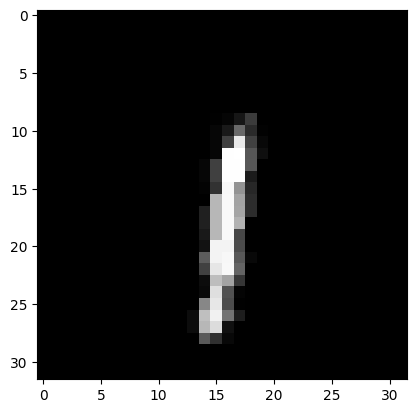

In [15]:
img = next(iter(train_loader))[0][8]
img_aug = (T.RandomAffine(degrees=(-30, 30), translate=(0.15, 0.15), scale=(0.7, 1.2)))(img)
plt.imshow(img_aug.squeeze(0), cmap="gray")

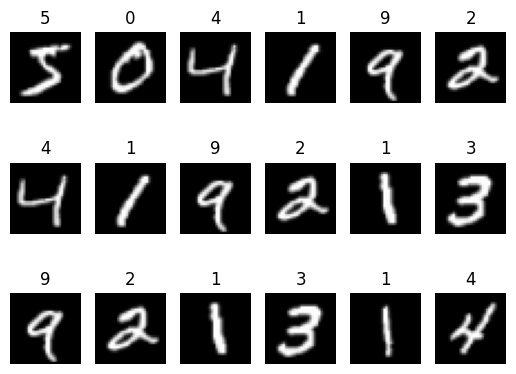

In [13]:
# test
train_features, train_labels = next(iter(train_loader))
fig, ax = plt.subplots(nrows=3, ncols=6)

for i in range(3):
    for j in range(6):
        img = train_features[i * 2 + j].squeeze()
        label = train_labels[i * 2 + j].item()

        ax[i, j].imshow(img, cmap="gray")
        ax[i, j].set_title(label)
        ax[i, j].axis("off");

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features_extract = nn.Sequential(
            nn.Conv2d(kernel_size=5, in_channels=1, out_channels=6),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(kernel_size=5, in_channels=6, out_channels=16),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        x = self.features_extract(x)
        x = torch.flatten(x, 1)
        prob = F.softmax(self.classifier(x), dim=1)

        return prob

In [10]:
NUM_EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_val_acc = 0

for layer in model.children():
    if hasattr(layer, "reset_parameters"):
        layer.reset_parameters()

In [11]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AI/best.pt'))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    model.train()

    total_train = correct_train = total_val = correct_val = train_loss = 0
    total_len = len(train_loader)

    for i, (img, label) in enumerate(train_loader):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.to(device)

        outputs = model(img)
        loss = cost(outputs, label)

        loss.backward()
        optimizer.step()

        total_train += label.size(0)
        correct_train += (torch.argmax(outputs, 1) == label).sum().item()
        train_loss += loss

        if (i % 100 == 0):
           print("Epoch [{}/{}], Batch: [{}/{}]".format(epoch + 1, NUM_EPOCHS, i, total_len))

    with torch.no_grad():
        model.eval()

        for i, (imgs, labels) in enumerate(test_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            correct_val += (torch.argmax(outputs, 1) == labels).sum().item()
            total_val += labels.size(0)

    print(
        "Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f}%, Val Accuraccy: {:.4f}%".format(
            epoch + 1,
            NUM_EPOCHS,
            train_loss.item(),
            correct_train / total_train * 100,
            correct_val / total_val * 100,
        )
    )

    if correct_val / total_val * 100 > best_val_acc:
        torch.save(model.state_dict(), "/content/drive/MyDrive/AI/best.pt")
        best_val_acc = correct_val / total_val * 100
        print("Saved model")